In [1]:
# Importing the necessary libraries
import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score


In [2]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Datasets and Pre-trained Models

Please follow the steps below to download and set up the necessary datasets and pre-trained models for your project:

### Step 1: Download the Files
Access the Google Drive links provided below to download the required resources:
- **Datasets**: [Download Datasets](https://drive.google.com/drive/folders/1kg9XImzrd9PpTtleQSz6l8uq82LV1sjV?usp=sharing) - Contains all required datasets.
- **Pre-Trained Models**: [Download Pre-Trained Models](https://drive.google.com/drive/folders/1i2-YizsmycWd47rxVMrfZ3GraEA64SDU?usp=sharing)

### Step 2: Upload the Files
After downloading, upload the datasets and models to your Google Drive or directly into your Google Colab environment.

### Step 3: Specify Paths
Provide the paths to the datasets and models in the code cells below. Replace `images_folder_path`, `masks_folder_path`, and `model_path` with the actual paths where you uploaded the files.


In [46]:
# Kvasir-seg dataset
# images_folder_path = "/content/drive/MyDrive/CV_PROJECT/Kvasir-SEG/validation/images"
# masks_folder_path = "/content/drive/MyDrive/CV_PROJECT/Kvasir-SEG/validation/masks"
# dataset_type = 'kvasir'
# model_path = "/content/drive/MyDrive/CV_PROJECT/Pre trained Models/DuckNet34 Kvasir Tf Model"

#CVC-ClinicDB
# images_folder_path = "/content/drive/MyDrive/CV_PROJECT/CVC-ClinicDB/validation/images"
# masks_folder_path = "/content/drive/MyDrive/CV_PROJECT/CVC-ClinicDB/validation/masks"
# dataset_type = 'cvc-clinicdb'
# model_path = "/content/drive/MyDrive/CV_PROJECT/Pre trained Models/DuckNet34 Cvc-ClinicDb Tf Model"

#CVC-ColonDB
images_folder_path = "/content/drive/MyDrive/CV_PROJECT/CVC-ColonDB/validation/images"
masks_folder_path = "/content/drive/MyDrive/CV_PROJECT/CVC-ColonDB/validation/masks"
dataset_type = 'cvc-colondb'
model_path = "/content/drive/MyDrive/CV_PROJECT/Pre trained Models/DuckNet34 Cvc-ColonDb Tf Model"

# ETIS-LaribPolypDB
# images_folder_path = "/content/drive/MyDrive/CV_PROJECT/ETIS-LaribPolypDB/train/images"
# masks_folder_path = "/content/drive/MyDrive/CV_PROJECT/ETIS-LaribPolypDB/train/masks"
# dataset_type = 'etis-laribpolypdb'
# model_path = "/content/drive/MyDrive/CV_PROJECT/Pre trained Models/DuckNet34 Etis-laribpolypdb Tf Model"


In [47]:
# Dice loss

import keras.backend as K
import tensorflow as tf


def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
    ground_truth = K.cast(ground_truth, tf.float32)
    predictions = K.cast(predictions, tf.float32)
    ground_truth = K.flatten(ground_truth)
    predictions = K.flatten(predictions)
    intersection = K.sum(predictions * ground_truth)
    union = K.sum(predictions) + K.sum(ground_truth)

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice


In [48]:
# ConvBlock2D

from keras.layers import BatchNormalization, add
from keras.layers import Conv2D

kernel_initializer = "he_uniform"


def conv_block_2D(
    x, filters, block_type, repeat=1, dilation_rate=1, size=3, padding="same"
):
    result = x

    for i in range(0, repeat):

        if block_type == "separated":
            result = separated_conv2D_block(result, filters, size=size, padding=padding)
        elif block_type == "duckv2":
            result = duckv2_conv2D_block(result, filters, size=size)
        elif block_type == "midscope":
            result = midscope_conv2D_block(result, filters)
        elif block_type == "widescope":
            result = widescope_conv2D_block(result, filters)
        elif block_type == "resnet":
            result = resnet_conv2D_block(result, filters, dilation_rate)
        elif block_type == "conv":
            result = Conv2D(
                filters,
                (size, size),
                activation="relu",
                kernel_initializer=kernel_initializer,
                padding=padding,
            )(result)
        elif block_type == "double_convolution":
            result = double_convolution_with_batch_normalization(
                result, filters, dilation_rate
            )

        else:
            return None

    return result


def duckv2_conv2D_block(x, filters, size):
    x = BatchNormalization(axis=-1)(x)
    x1 = widescope_conv2D_block(x, filters)

    x2 = midscope_conv2D_block(x, filters)

    x3 = conv_block_2D(x, filters, "resnet", repeat=1)

    x4 = conv_block_2D(x, filters, "resnet", repeat=2)

    x5 = conv_block_2D(x, filters, "resnet", repeat=3)

    x6 = separated_conv2D_block(x, filters, size=6, padding="same")

    x = add([x1, x2, x3, x4, x5, x6])

    x = BatchNormalization(axis=-1)(x)

    return x


def separated_conv2D_block(x, filters, size=3, padding="same"):
    x = Conv2D(
        filters,
        (1, size),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding=padding,
    )(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(
        filters,
        (size, 1),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding=padding,
    )(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def midscope_conv2D_block(x, filters):
    x = Conv2D(
        filters,
        (3, 3),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=1,
    )(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(
        filters,
        (3, 3),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=2,
    )(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def widescope_conv2D_block(x, filters):
    x = Conv2D(
        filters,
        (3, 3),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=1,
    )(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(
        filters,
        (3, 3),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=2,
    )(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(
        filters,
        (3, 3),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=3,
    )(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def resnet_conv2D_block(x, filters, dilation_rate=1):
    x1 = Conv2D(
        filters,
        (1, 1),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=dilation_rate,
    )(x)

    x = Conv2D(
        filters,
        (3, 3),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=dilation_rate,
    )(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(
        filters,
        (3, 3),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=dilation_rate,
    )(x)
    x = BatchNormalization(axis=-1)(x)
    x_final = add([x, x1])

    x_final = BatchNormalization(axis=-1)(x_final)

    return x_final


def double_convolution_with_batch_normalization(x, filters, dilation_rate=1):
    x = Conv2D(
        filters,
        (3, 3),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=dilation_rate,
    )(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(
        filters,
        (3, 3),
        activation="relu",
        kernel_initializer=kernel_initializer,
        padding="same",
        dilation_rate=dilation_rate,
    )(x)
    x = BatchNormalization(axis=-1)(x)

    return x


In [49]:
# DuckNet
import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D
from keras.layers import add
from keras.models import Model

# from CustomLayers.ConvBlock2D import conv_block_2D

kernel_initializer = 'he_uniform'
interpolation = "nearest"


def create_model(img_height, img_width, input_chanels, out_classes, starting_filters):
    input_layer = tf.keras.layers.Input((img_height, img_width, input_chanels))

    print('Starting DUCK-Net')

    p1 = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(input_layer)
    p2 = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(p1)
    p3 = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(p2)
    p4 = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(p3)
    p5 = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(p4)

    t0 = conv_block_2D(input_layer, starting_filters, 'duckv2', repeat=1)

    l1i = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(t0)
    s1 = add([l1i, p1])
    t1 = conv_block_2D(s1, starting_filters * 2, 'duckv2', repeat=1)

    l2i = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(t1)
    s2 = add([l2i, p2])
    t2 = conv_block_2D(s2, starting_filters * 4, 'duckv2', repeat=1)

    l3i = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(t2)
    s3 = add([l3i, p3])
    t3 = conv_block_2D(s3, starting_filters * 8, 'duckv2', repeat=1)

    l4i = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(t3)
    s4 = add([l4i, p4])
    t4 = conv_block_2D(s4, starting_filters * 16, 'duckv2', repeat=1)

    l5i = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(t4)
    s5 = add([l5i, p5])
    t51 = conv_block_2D(s5, starting_filters * 32, 'resnet', repeat=2)
    t53 = conv_block_2D(t51, starting_filters * 16, 'resnet', repeat=2)

    l5o = UpSampling2D((2, 2), interpolation=interpolation)(t53)
    c4 = add([l5o, t4])
    q4 = conv_block_2D(c4, starting_filters * 8, 'duckv2', repeat=1)

    l4o = UpSampling2D((2, 2), interpolation=interpolation)(q4)
    c3 = add([l4o, t3])
    q3 = conv_block_2D(c3, starting_filters * 4, 'duckv2', repeat=1)

    l3o = UpSampling2D((2, 2), interpolation=interpolation)(q3)
    c2 = add([l3o, t2])
    q6 = conv_block_2D(c2, starting_filters * 2, 'duckv2', repeat=1)

    l2o = UpSampling2D((2, 2), interpolation=interpolation)(q6)
    c1 = add([l2o, t1])
    q1 = conv_block_2D(c1, starting_filters, 'duckv2', repeat=1)

    l1o = UpSampling2D((2, 2), interpolation=interpolation)(q1)
    c0 = add([l1o, t0])
    z1 = conv_block_2D(c0, starting_filters, 'duckv2', repeat=1)

    output = Conv2D(out_classes, (1, 1), activation='sigmoid')(z1)

    model = Model(inputs=input_layer, outputs=output)

    return model


In [50]:
import glob
import numpy as np
from PIL import Image
from skimage.io import imread
from tqdm import tqdm
from pathlib import Path

img_size = 352
filters = 34 # Number of filters, the paper presents the results with 17 and 34

model_type = "DuckNet"

def load_data(img_height, img_width, images_to_be_loaded, dataset):
    if dataset == "kvasir" or dataset == "etis-laribpolypdb" or dataset == "cvc-clinicdb" or dataset == "cvc-colondb":
        extension = "*.jpg"
    else:
        raise ValueError("Unsupported dataset type.")

    images_path = Path(images_folder_path)
    masks_path = Path(masks_folder_path)

    train_image_paths = list(images_path.glob(extension))

    if images_to_be_loaded == -1 or images_to_be_loaded > len(train_image_paths):
        images_to_be_loaded = len(train_image_paths)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print(f"Resizing validation images and masks: {images_to_be_loaded}")
    for n, image_path in tqdm(enumerate(train_image_paths), total=images_to_be_loaded):
        if n >= images_to_be_loaded:
            break

        mask_path = masks_path / image_path.name

        image = Image.open(image_path).resize((img_width, img_height))
        image = np.array(image) / 255.0

        mask = Image.open(mask_path).resize((img_width, img_height))
        mask = np.array(mask)
        mask = np.where(mask >= 127, 1, 0).astype(np.uint8)

        X_train[n] = image
        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

# Example usage
img_height, img_width = 352, 352
images_to_be_loaded = -1 # Load all images
# dataset_type = 'kvasir'  # Options: 'kvasir', 'cvc-clinicdb', 'cvc-colondb', 'etis-laribpolypdb'

X, Y = load_data(img_height, img_width, images_to_be_loaded, dataset_type)
print(f"Loaded {len(X)} images and masks.")


Resizing validation images and masks: 38


100%|██████████| 38/38 [00:28<00:00,  1.32it/s]

Loaded 38 images and masks.


# Evaluation of pretrained models

In [51]:
import numpy as np
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score, accuracy_score
import tensorflow as tf

# Creating the model
model = create_model(img_height=img_size, img_width=img_size, input_chanels=3, out_classes=1, starting_filters=filters)


# Load the model
print("Loading the model")
model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss': dice_metric_loss})

# Perform predictions
print("Predicting...")
predictions = model.predict(X, batch_size=4)

# Threshold predictions to binary (0 or 1) using 0.5 as the cutoff
predicted_masks = (predictions > 0.5).astype(int)

# Flatten the arrays for metric calculations
predictions_flat = predicted_masks.flatten()
y_true_flat = Y.flatten()

# Compute metrics
dice_score = f1_score(y_true_flat, predictions_flat)
miou_score = jaccard_score(y_true_flat, predictions_flat)
precision = precision_score(y_true_flat, predictions_flat)
recall = recall_score(y_true_flat, predictions_flat)
accuracy = accuracy_score(y_true_flat, predictions_flat)

# Print results
print(f"Dice/F1 Score: {dice_score}")
print(f"Mean IoU: {miou_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

# Optionally, save the results to a file
results_filename = f'results_{model_type}_{filters}_{dataset_type}_evaluation.txt'
with open(results_filename, 'w') as file:
    file.write(f"Dice/F1 Score: {dice_score}\n")
    file.write(f"Mean IoU: {miou_score}\n")
    file.write(f"Precision: {precision}\n")
    file.write(f"Recall: {recall}\n")
    file.write(f"Accuracy: {accuracy}\n")

print(f"Results saved to: {results_filename}")


Starting DUCK-Net
Loading the model
Predicting...
10/10 [==============================] - 11s 644ms/step
Dice/F1 Score: 0.928508137514442
Mean IoU: 0.8665564060939909
Precision: 0.9240577841676596
Recall: 0.933001564991005
Accuracy: 0.991654617156916
Results saved to: results_DuckNet_34_cvc-colondb_evaluation.txt


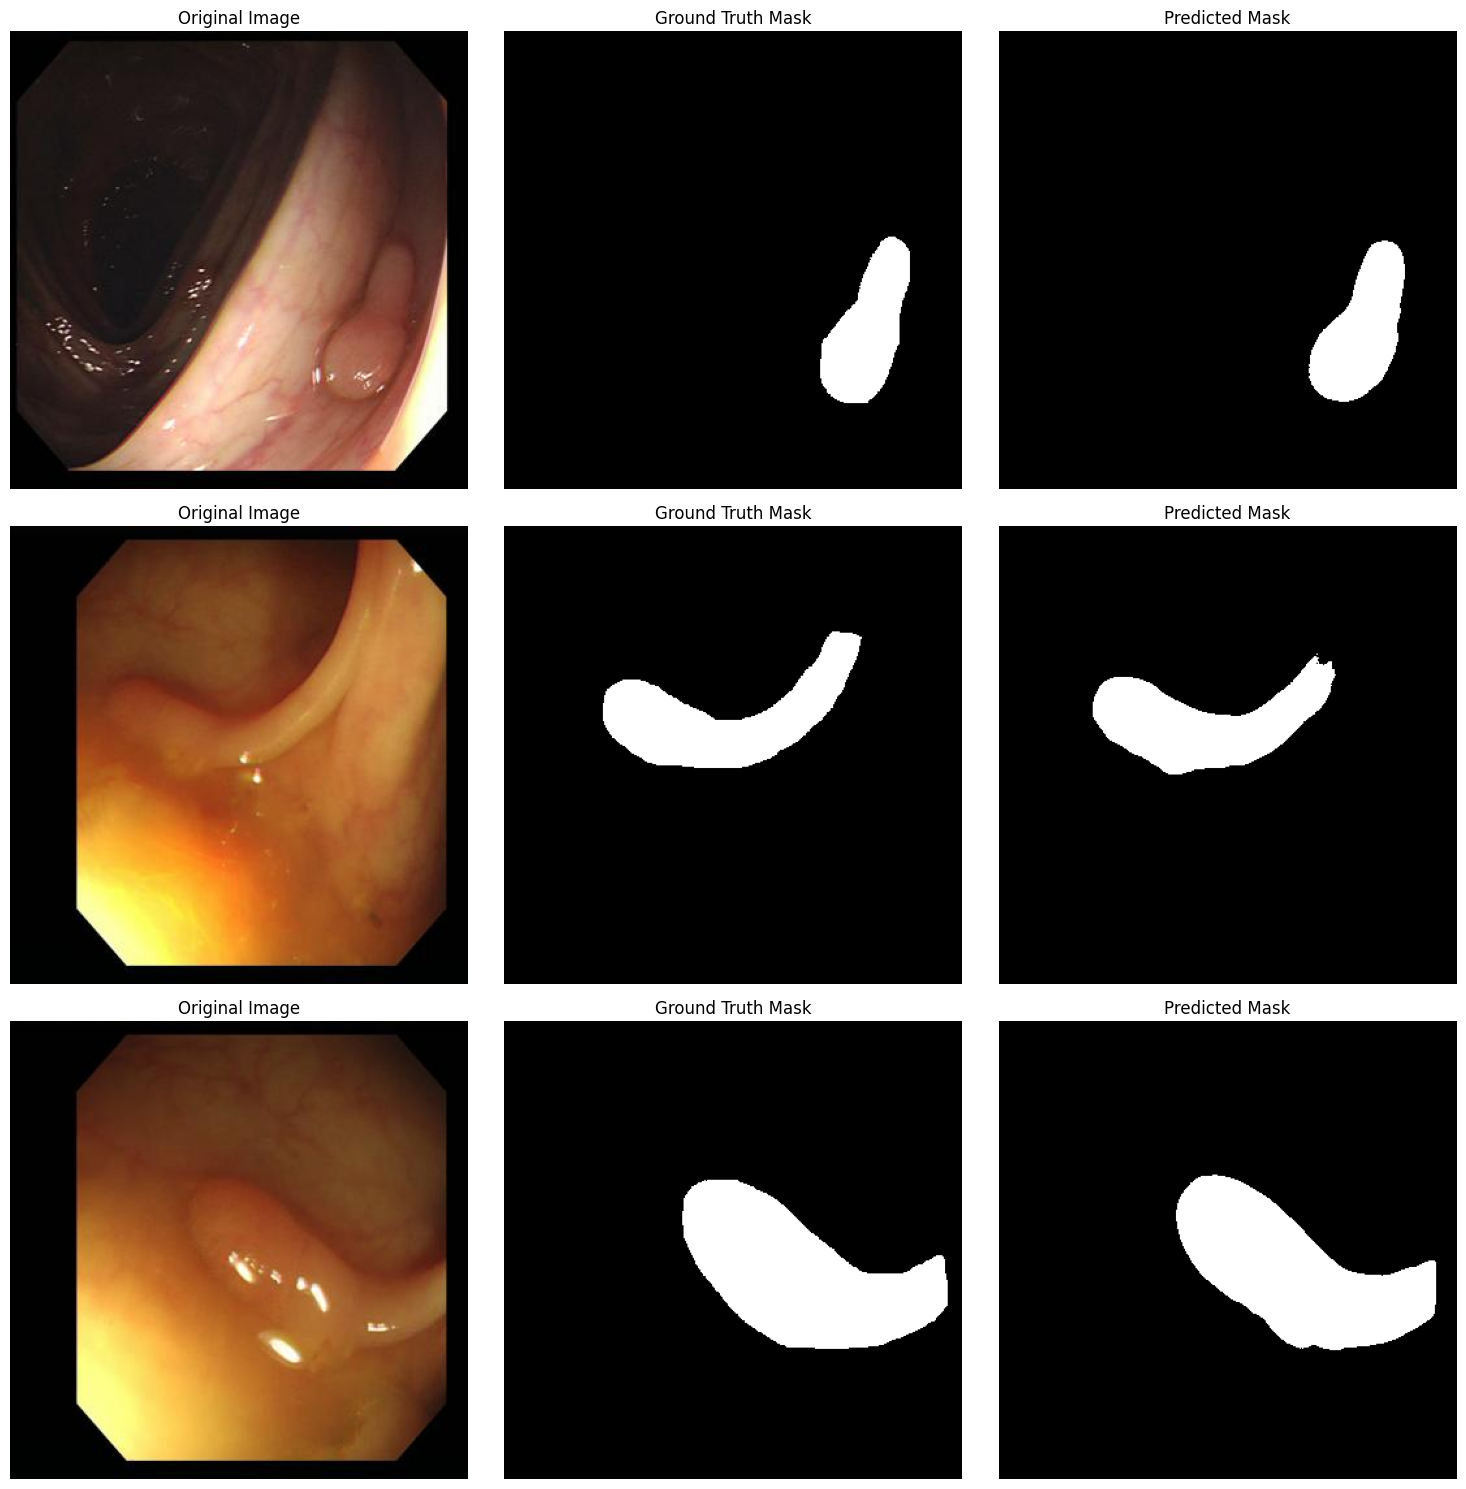

In [52]:
import matplotlib.pyplot as plt

save_path = f'Results_Plot_{model_type}_{filters}_{dataset_type}.png'

def plot_predictions(images, masks, predictions, num_samples=3, save_path='predictions_plot.png'):
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Randomly select an index
        idx = np.random.randint(0, len(images))

        # Original Image
        axs[i, 0].imshow(images[idx])
        axs[i, 0].title.set_text('Original Image')
        axs[i, 0].axis('off')

        # Ground Truth Mask
        axs[i, 1].imshow(masks[idx].squeeze(), cmap='gray')
        axs[i, 1].title.set_text('Ground Truth Mask')
        axs[i, 1].axis('off')

        # Predicted Mask
        axs[i, 2].imshow(predictions[idx].squeeze(), cmap='gray')
        axs[i, 2].title.set_text('Predicted Mask')
        axs[i, 2].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(save_path)  # Save the figure to a file
    plt.show()  # Display the plot

# Convert predictions to binary using the threshold of 0.5
predicted_masks_binary = (predictions > 0.5).astype(np.float32)

# Plotting examples and saving the plot
plot_predictions(X, Y, predicted_masks_binary, num_samples=3, save_path=save_path)
